In [24]:
#SIPaKMeD Veritabanı, Pap smear slaytlarının 966 küme hücre görüntüsünden manuel olarak kırpılmış izole edilmiş hücrelerin 4049 görüntüsünden oluşur. 
#Bu görüntüler, optik mikroskoba uyarlanmış bir CCD kamera aracılığıyla elde edildi. 
#Hücre görüntüleri normal, anormal ve iyi huylu hücreleri içeren beş kategoriye ayrılmıştır.


from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os
from keras.applications import imagenet_utils
import tensorflow
import cv2

from keras.applications.densenet import DenseNet201
from keras.applications.nasnet import NASNetMobile
from keras.applications.mobilenet_v2 import MobileNetV2
from keras.applications.inception_resnet_v2 import InceptionResNetV2
from keras.applications.resnet_v2 import ResNet152V2
from keras.applications.vgg19 import VGG19
#from keras.applications.efficientnet_v2 import EfficientNetV2L
from keras.applications.efficientnet import EfficientNetB7
from sklearn.metrics import accuracy_score

from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler

imgdata = []
labels = []
compressed_img_size = 32
celltypes = ['im_Koilocytotic', 'im_Metaplastic', 'im_Dyskeratotic', 'im_Parabasal', 'im_Superficial-Intermediate']
path = ["../input/cervical-cancer-largest-dataset-sipakmed/" + celltype  + "/" + celltype + "/CROPPED/" for celltype in celltypes]


#Sadece görüntüyü okuma kısmı hazır kod filter kısmını okuduğum makaledeki gibi medyan filter ile değiştirip test etmeyi planlıyorum.

# Low pass filter
LOW_PASS_FILTER = False
# High pass filter
HIGH_PASS_FILTER = False

cur_label = -1
for celltype in path:
    cur_label += 1 
    cellimages = os.listdir(celltype)
    for cellimage in cellimages:
        if cellimage.lower().endswith(".bmp"):
            # Mark each cell with a cell type
            labels.append(cur_label)
            img = cv2.imread(celltype+cellimage)
            img = np.array(Image.fromarray(img, 'RGB').resize((compressed_img_size, compressed_img_size)))
            if LOW_PASS_FILTER:
                img = cv2.GaussianBlur(img, (3, 3), cv2.BORDER_DEFAULT)
            elif HIGH_PASS_FILTER:
                img = img - cv2.GaussianBlur(img, (3, 3), cv2.BORDER_DEFAULT) + 127
            imgdata.append(img)

labels = np.array(labels)
imgdata = np.array(imgdata)
print(labels,imgdata)


[0 0 0 ... 4 4 4] [[[[255 255 255]
   [255 255 255]
   [255 255 255]
   ...
   [219 181 240]
   [209 166 228]
   [214 173 242]]

  [[255 255 255]
   [255 255 255]
   [255 247 253]
   ...
   [239 201 247]
   [208 173 219]
   [215 176 232]]

  [[255 255 255]
   [255 255 255]
   [255 227 251]
   ...
   [255 224 255]
   [232 192 234]
   [214 174 221]]

  ...

  [[255 255 255]
   [255 255 255]
   [255 255 255]
   ...
   [255 255 255]
   [255 255 255]
   [255 255 255]]

  [[255 255 255]
   [255 255 255]
   [255 255 255]
   ...
   [255 255 255]
   [255 255 255]
   [255 255 255]]

  [[255 255 255]
   [255 255 255]
   [255 255 255]
   ...
   [255 255 255]
   [255 255 255]
   [255 255 255]]]


 [[[213 195 195]
   [208 192 194]
   [207 189 193]
   ...
   [216 199 204]
   [217 199 204]
   [214 199 204]]

  [[209 192 194]
   [202 184 192]
   [190 168 191]
   ...
   [215 199 204]
   [216 198 205]
   [214 196 203]]

  [[206 188 195]
   [190 171 195]
   [155 137 206]
   ...
   [215 199 202]
   [216 19

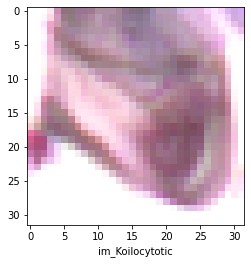

In [14]:
def show_the_image(i):
    plt.imshow(imgdata[i])
    plt.xlabel(celltypes[labels[i]])
    
show_the_image(0)

In [15]:
#https://keras.io/api/applications/ bu linkten modellerin performanslarını inceleyip modelleri seçtim.
#include_top false değerinde sadece özellik çıkarma katmanları modele dahil edildi.Sanırım sorduğunuz soru bu kısımdı.

model_densenet = DenseNet201(weights = 'imagenet', include_top = False)
model_nasnet = NASNetMobile(weights = 'imagenet', include_top = False)
model_mobilenet = MobileNetV2(weights = 'imagenet', include_top = False)
#model_ıncepnet = InceptionResNetV2(weights = 'imagenet', include_top = False)
model_resnet = ResNet152V2(weights = 'imagenet', include_top = False)
model_vgg = VGG19(weights = 'imagenet', include_top = False)


#features_nasnet = model_nasnet.predict(imgdata, batch_size=32)
features_densenet = model_densenet.predict(imgdata, batch_size=32)
features_mobilenet = model_mobilenet.predict(imgdata, batch_size=32)
#features_ıncepnet = model_ıncepnet.predict(imgdata, batch_size=32)
features_resnet = model_resnet.predict(imgdata, batch_size=32)
features_vgg = model_vgg.predict(imgdata, batch_size=32)

print(features_densenet.shape)
#print(features_nasnet.shape)
print(features_mobilenet.shape)
#print(features_ıncepnet.shape)
print(features_resnet.shape)
print(features_vgg.shape)

(4049, 1, 1, 1920)
(4049, 1, 1, 1280)
(4049, 1, 1, 2048)
(4049, 1, 1, 512)


In [16]:
#Normalde diğer modeller ile birleştiriyorum. Test ederken birleştirmeden denemişim en son.

extracted_features = []

for f_d , label in zip(features_densenet,labels):
    f_d = f_d.reshape(f_d.shape[0] * f_d.shape[1] * f_d.shape[2])    
    f_d = np.append(f_d, label)
    extracted_features.append(f_d)
    
extracted_features = np.array(extracted_features)

print(extracted_features.shape)

(4049, 1921)


In [18]:
X = extracted_features[:, 0:-1]
y = extracted_features[:, -1]

In [19]:

# Feature Scaling (Özellik Ölçeklendirme)
###################
# StandardScaler: Klasik standartlaştırma. Ortalamayı çıkar, standart sapmaya böl. z = (x - u) / s
###################
ss = StandardScaler()
ss = ss.fit_transform(X)

# RobustScaler: Medyanı çıkar iqr'a böl.
###################
rs = RobustScaler()
rs = rs.fit_transform(X)
###################

# MinMaxScaler: Verilen 2 değer arasında değişken dönüşümü
###################

# X_std = (X - X.min(axis=0)) / (X.max(axis=0) - X.min(axis=0))
# X_scaled = X_std * (max - min) + min

mms = MinMaxScaler()
mms = mms.fit_transform(X)

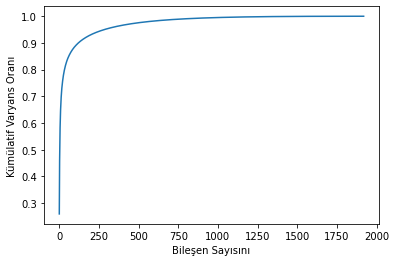

array([0.25979594, 0.37565722, 0.45764525, 0.51151527, 0.55328633,
       0.58235606, 0.60934188, 0.63142487, 0.64787506, 0.6626846 ,
       0.67559694, 0.6875589 , 0.69806002, 0.70707243, 0.71566546,
       0.72341467, 0.73030802, 0.73667637, 0.74235367, 0.74766631,
       0.75277719, 0.75771824, 0.76257198, 0.76715202, 0.77148421,
       0.77536202, 0.77892357, 0.78243975, 0.78590488, 0.78923323,
       0.7923848 , 0.79532081, 0.79817887, 0.80093405, 0.80364649,
       0.80623623, 0.80874482, 0.81120751, 0.81355344, 0.81581532,
       0.81796018, 0.82008929, 0.82215301, 0.8241363 , 0.82610266,
       0.82802505, 0.82989254, 0.83164363, 0.83338541, 0.83509292,
       0.83671002, 0.8382583 , 0.83977752, 0.8412873 , 0.84277639,
       0.84421206, 0.84559481, 0.84695915, 0.84828898, 0.84959109,
       0.85087822, 0.85213767, 0.85338225, 0.85461184, 0.85579947,
       0.85695849, 0.85809729, 0.85922307, 0.8603191 , 0.86140493,
       0.86248168, 0.86353732, 0.86457952, 0.86560369, 0.86660

In [20]:
# Optimum Bileşen Sayısı
################################

pca = PCA().fit(mms)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel("Bileşen Sayısını")
plt.ylabel("Kümülatif Varyans Oranı")
plt.show()

################################
# Final PCA'in Oluşturulması
################################
pca = PCA(n_components=0.97) #tabloya göre belirledim.
X = pca.fit_transform(mms)

pca.explained_variance_ratio_
np.cumsum(pca.explained_variance_ratio_)


In [21]:
import lightgbm as lgb
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

In [22]:
# Optimum parametre seçimi
######################################################

knn_params = {"n_neighbors": range(2, 50)}

cart_params = {'max_depth': range(1, 20),
               "min_samples_split": range(2, 30)}

rf_params = {"max_depth": [8, 15, None],
             "max_features": [5, 7, "auto"],
             "min_samples_split": [15, 20],
             "n_estimators": [200, 300]}

xgboost_params = {"learning_rate": [0.1, 0.01],
                  "max_depth": [5, 8],
                  "n_estimators": [100, 200]}

lightgbm_params = {"learning_rate": [0.01, 0.1],
                   "n_estimators": [300, 500]}


classifiers = [('KNN', KNeighborsClassifier(), knn_params),
               ("CART", DecisionTreeClassifier(), cart_params),
               ("RF", RandomForestClassifier(), rf_params),
               ('XGBoost', XGBClassifier(eval_metric='logloss'), xgboost_params),
               ('LightGBM', lgb.LGBMClassifier(), lightgbm_params),
               ('LR', LogisticRegression()),
                ("SVC", SVC()),
                ('Adaboost', AdaBoostClassifier()),
                ('GBM', GradientBoostingClassifier())]

In [ ]:

def hyperparameter_optimization(X, y, cv=3, scoring="accuracy"):
    print("Hyperparameter Optimization....")
    best_models = {}
    for name, classifier, params in classifiers:
        print(f"########## {name} ##########")
        gs_best = GridSearchCV(classifier, params, cv=cv, n_jobs=-1, verbose=False).fit(X, y)
        final_model = classifier.set_params(**gs_best.best_params_)

        cv_results = cross_validate(final_model, X, y, cv=cv, scoring=scoring) #test ve eğitim verisi için cross validate yöntemini kullandım.
        print(f"{scoring} (After): {round(cv_results['test_score'].mean(), 4)}")
        print(f"{name} best params: {gs_best.best_params_}", end="\n\n")
        best_models[name] = final_model
    return best_models

#En iyi model seçimi 
def voting_classifier(best_models, X, y):
    print("Voting Classifier...")
    #Uzun sürdüğü için diğer modelleri de dahil etmedim,edeceğim.
    voting_clf = VotingClassifier(estimators=[('KNN', best_models["KNN"]), ('RF', best_models["RF"]),
                                              ('LightGBM', best_models["LightGBM"])],
                                  voting='soft').fit(X, y)
    #değerlendirme metrikleri
    cv_results = cross_validate(voting_clf, X, y, cv=3, scoring=["accuracy", "f1", "roc_auc"])
    print(f"Accuracy: {cv_results['test_accuracy'].mean()}")
    print(f"F1Score: {cv_results['test_f1'].mean()}")
    print(f"ROC_AUC: {cv_results['test_roc_auc'].mean()}")
    return voting_clf



def main():
    best_models = hyperparameter_optimization(X, y)
    voting_clf = voting_classifier(best_models, X, y)

main()

Hyperparameter Optimization....
########## KNN ##########
accuracy (After): 0.8402
KNN best params: {'n_neighbors': 3}

########## CART ##########
accuracy (After): 0.7024
CART best params: {'max_depth': 7, 'min_samples_split': 5}

########## RF ##########
accuracy (After): 0.837
RF best params: {'max_depth': 15, 'max_features': 'auto', 'min_samples_split': 15, 'n_estimators': 200}

########## XGBoost ##########
